# Regression of all intensities (both detected and not)
Regression has to be done by ion (mol+adduct), because we don't have a good way to combine intensities across adducts.

In [2]:
from pathlib import Path
import scipy.stats
from sklearn.metrics import mean_squared_error
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
plt.style.use('dark_background')

plots_dir = Path.cwd() / "../plots"
results_dir = Path.cwd() / "../results/regression_on_all"


In [3]:
filenames = {
    "all_feat": "regr_results_all_feat.csv",
    "fingerprints_feat": "regr_results_fingerprints_feat.csv",
    "mol_feat": "regr_results_mol_feat.csv",
    "random_feat": "regr_results_random_feat.csv",
    "no_feat": "regr_results_no_feat.csv",
}

INCLUDE_NOT_DETECTED_IN_SCORE = True

In [4]:
metric = "Spearman's R"

# compute Spearman's/Pearson's correlation and mean squared error for each matrix/polarity/regressor
scores = ["Spearman's R", 'S pval', "Pearson's R", 'P pval', 'RMSE', 'RMSE/std', 'non-zero obs']
models_results = pd.DataFrame()
model_metrics = pd.DataFrame(columns = ['train_setup', 'matrix', 'polarity', 'model_type'] + scores)
model_metrics_global = pd.DataFrame(columns = ['train_setup', 'model_type'] + scores)
counter = 0
counter_global = 0

for train_setup in filenames:
    result_filename = filenames[train_setup]
    loc_models_results = pd.read_csv(results_dir / result_filename, index_col = 0)
    loc_models_results = loc_models_results.rename(columns={'Matrix short': 'matrix',
                                                          'Polarity': 'polarity'})

    # -----------------------------------------
    # Add extra baseline randomly guessing:
    # -----------------------------------------

    baseline_results = loc_models_results.drop(columns=["regressor", "prediction", "fold"]).drop_duplicates().reset_index(drop=True)
    baseline_results["prediction"] = 0
    baseline_results["fold"] = 0
    baseline_results["regressor"] = "random_guess"

    for (matrix, polarity), rows in baseline_results.groupby(['matrix', 'polarity']):
        detected_prob = float((rows["observed_value"] > 0).sum()) / len(rows)
        prediction = (np.random.random(size=len(rows)) < detected_prob).astype('int') * 2.
        baseline_results.loc[rows.index.to_list(), "prediction"] = prediction

    loc_models_results = pd.concat([loc_models_results, baseline_results])



    for (matrix, polarity, regressor), rows in loc_models_results.groupby(['matrix', 'polarity', 'regressor']):
        # remove zero intensity molecules if needed (optional)
        if not INCLUDE_NOT_DETECTED_IN_SCORE:
            rows = rows[rows['observed_value']!=0]

        spearman = scipy.stats.spearmanr(rows.observed_value, rows.prediction)
        pearson = scipy.stats.pearsonr(rows.observed_value, rows.prediction)
        mse = mean_squared_error(rows.observed_value, rows.prediction, squared = False)
        mse_std = mse / rows['observed_value'].std()
        model_metrics.loc[counter] = [train_setup, matrix, polarity, regressor, spearman[0], spearman[1],
                                           pearson[0], pearson[1], mse, mse_std,
                                           rows[rows['observed_value']!=0].shape[0]]
        counter += 1

    loc_models_results["train_setup"] = train_setup
    models_results = pd.concat([models_results, loc_models_results])

    # Compute global scores:
    for (regressor), rows in loc_models_results.groupby(['regressor']):
        # remove zero intensity molecules if needed (optional)
        if not INCLUDE_NOT_DETECTED_IN_SCORE:
            rows = rows[rows['observed_value']!=0]

        spearman = scipy.stats.spearmanr(rows.observed_value, rows.prediction)
        pearson = scipy.stats.pearsonr(rows.observed_value, rows.prediction)
        mse = mean_squared_error(rows.observed_value, rows.prediction, squared = False)
        mse_std = mse / rows['observed_value'].std()
        model_metrics_global.loc[counter_global] = [train_setup, regressor, spearman[0], spearman[1],
                                           pearson[0], pearson[1], mse, mse_std,
                                           rows[rows['observed_value']!=0].shape[0]]
        counter_global += 1


/Users/alberto-mac/miniforge3/envs/pyTorch/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/alberto-mac/miniforge3/envs/pyTorch/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/alberto-mac/miniforge3/envs/pyTorch/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/alberto-mac/miniforge3/envs/pyTorch/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInpu

Plot performances of different models, with different input features:

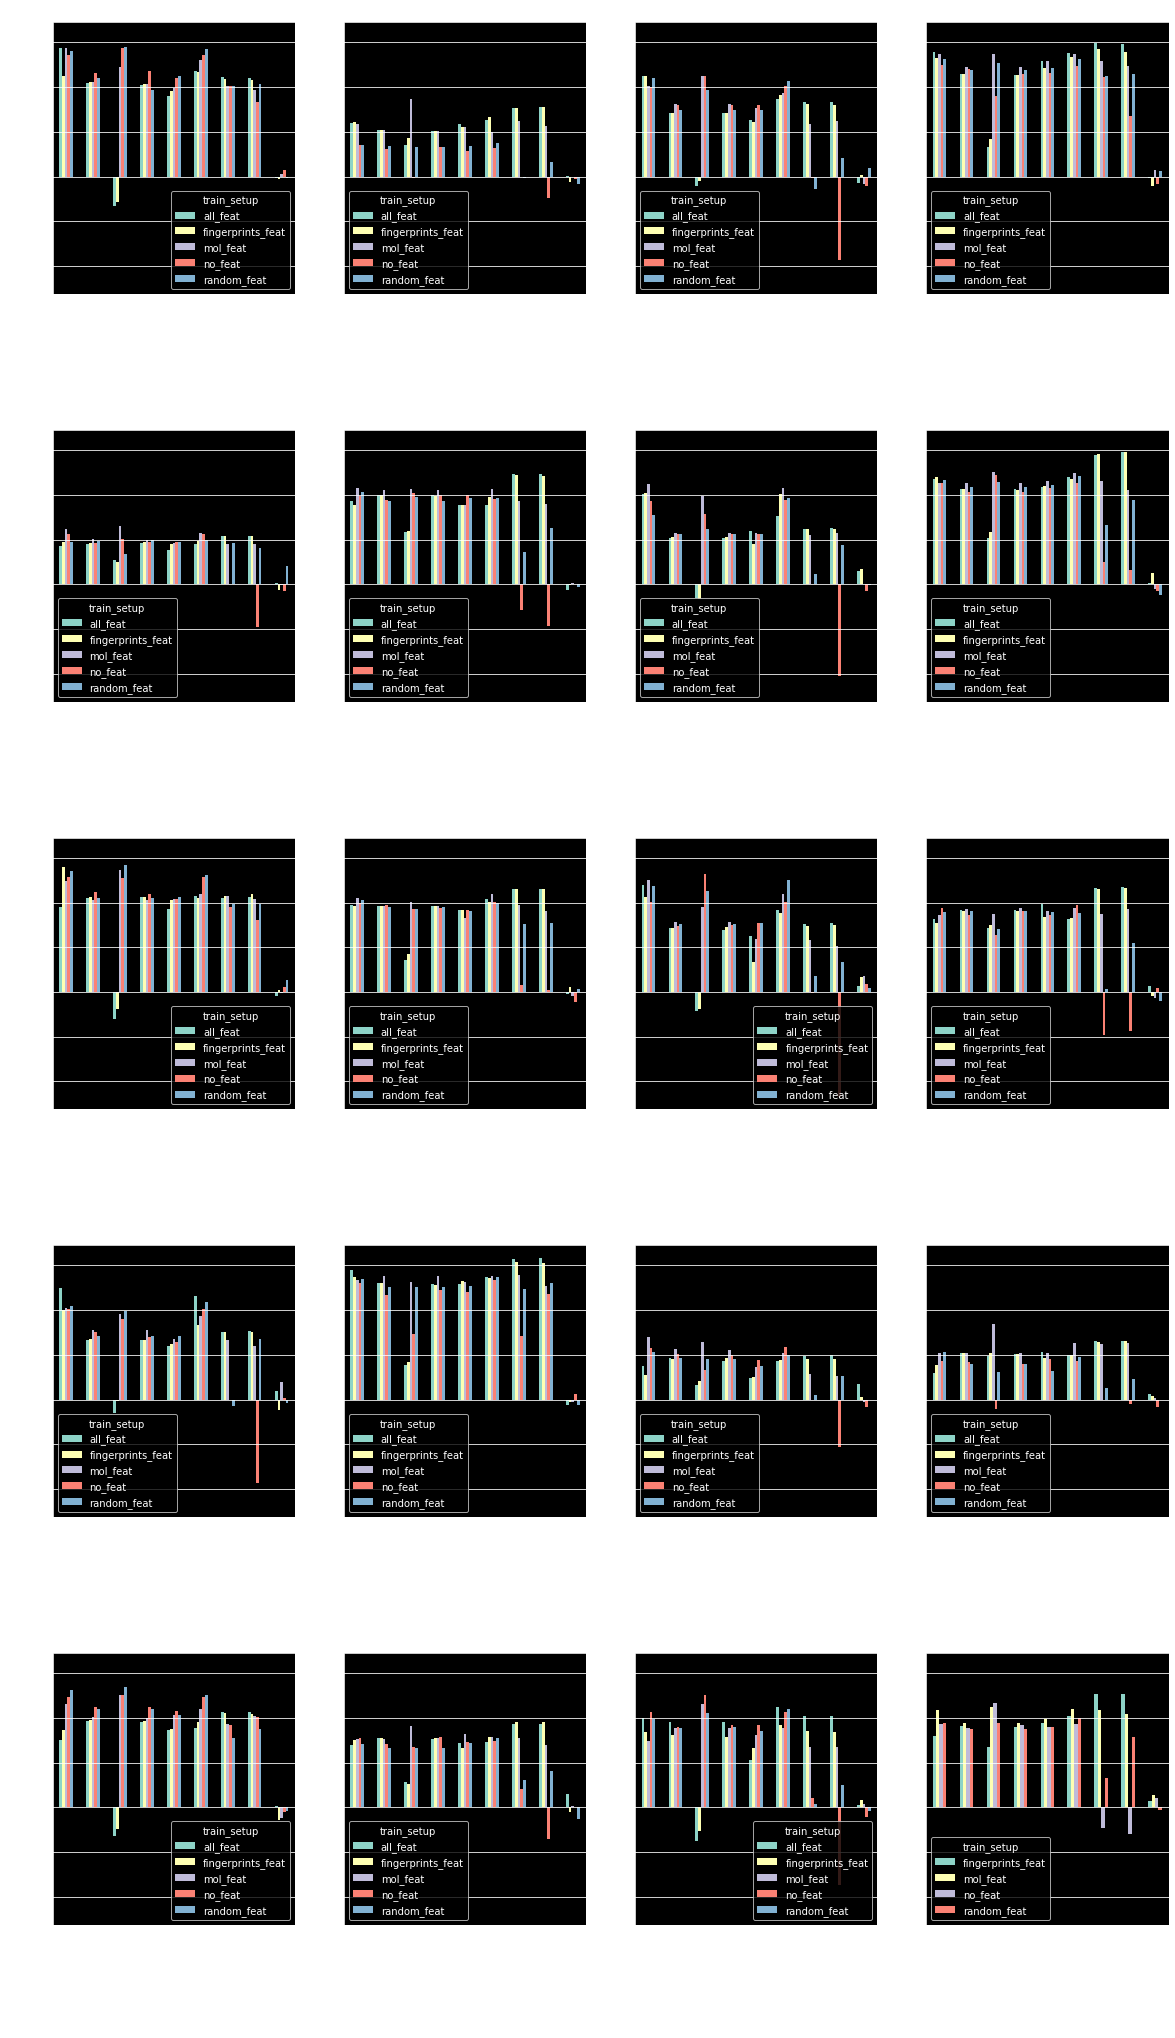

In [5]:
fig, axes = plt.subplots(ncols=4,nrows=5, sharey=True, figsize= (20, 35))
ax_list = axes.flat

metric = "Spearman's R"
#metric = "RMSE"

i = 0
for (matrix, polarity), rows in model_metrics.groupby(['matrix', 'polarity']):
    nb_obs = rows['non-zero obs'].drop_duplicates().values[0]
    rows = rows.set_index(['model_type', "train_setup"], drop = True).sort_values( by = ["train_setup", metric])
    rows = rows.unstack("train_setup")
    rows[metric].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity} ({nb_obs})")
    ax_list[i].set_ylabel(metric)
    ax_list[i].grid(axis='y')
    # if i != 0:
    #     ax_list[i].get_legend().set_visible(False)
    i+=1

plt.subplots_adjust(hspace=0.5)
plt.show()


For each matrix, get the max "Spearman's R" achieved, and compute difference between this max value and
 the value achieved by each model (compare bars of same colors, not across colors). MLP seems to be the best in all setups:

<AxesSubplot:xlabel='model_type'>

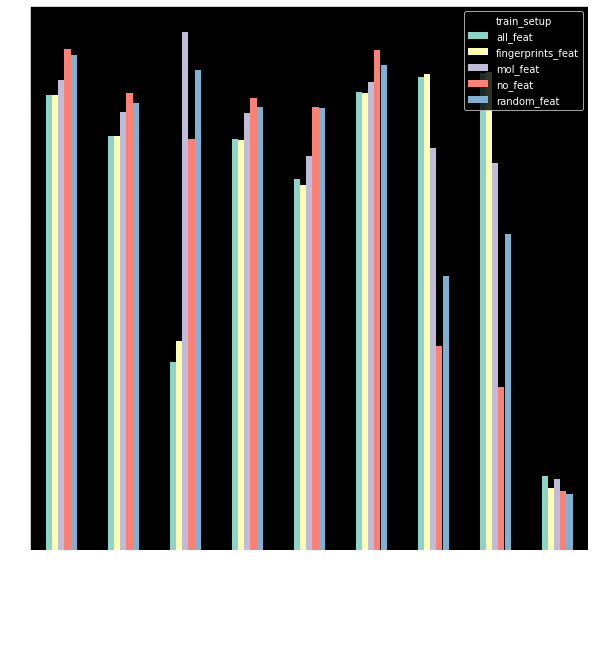

In [6]:
model_metrics_global.set_index(["model_type", "train_setup"], drop=True)[metric].unstack("train_setup").plot.bar(figsize=(10,10))

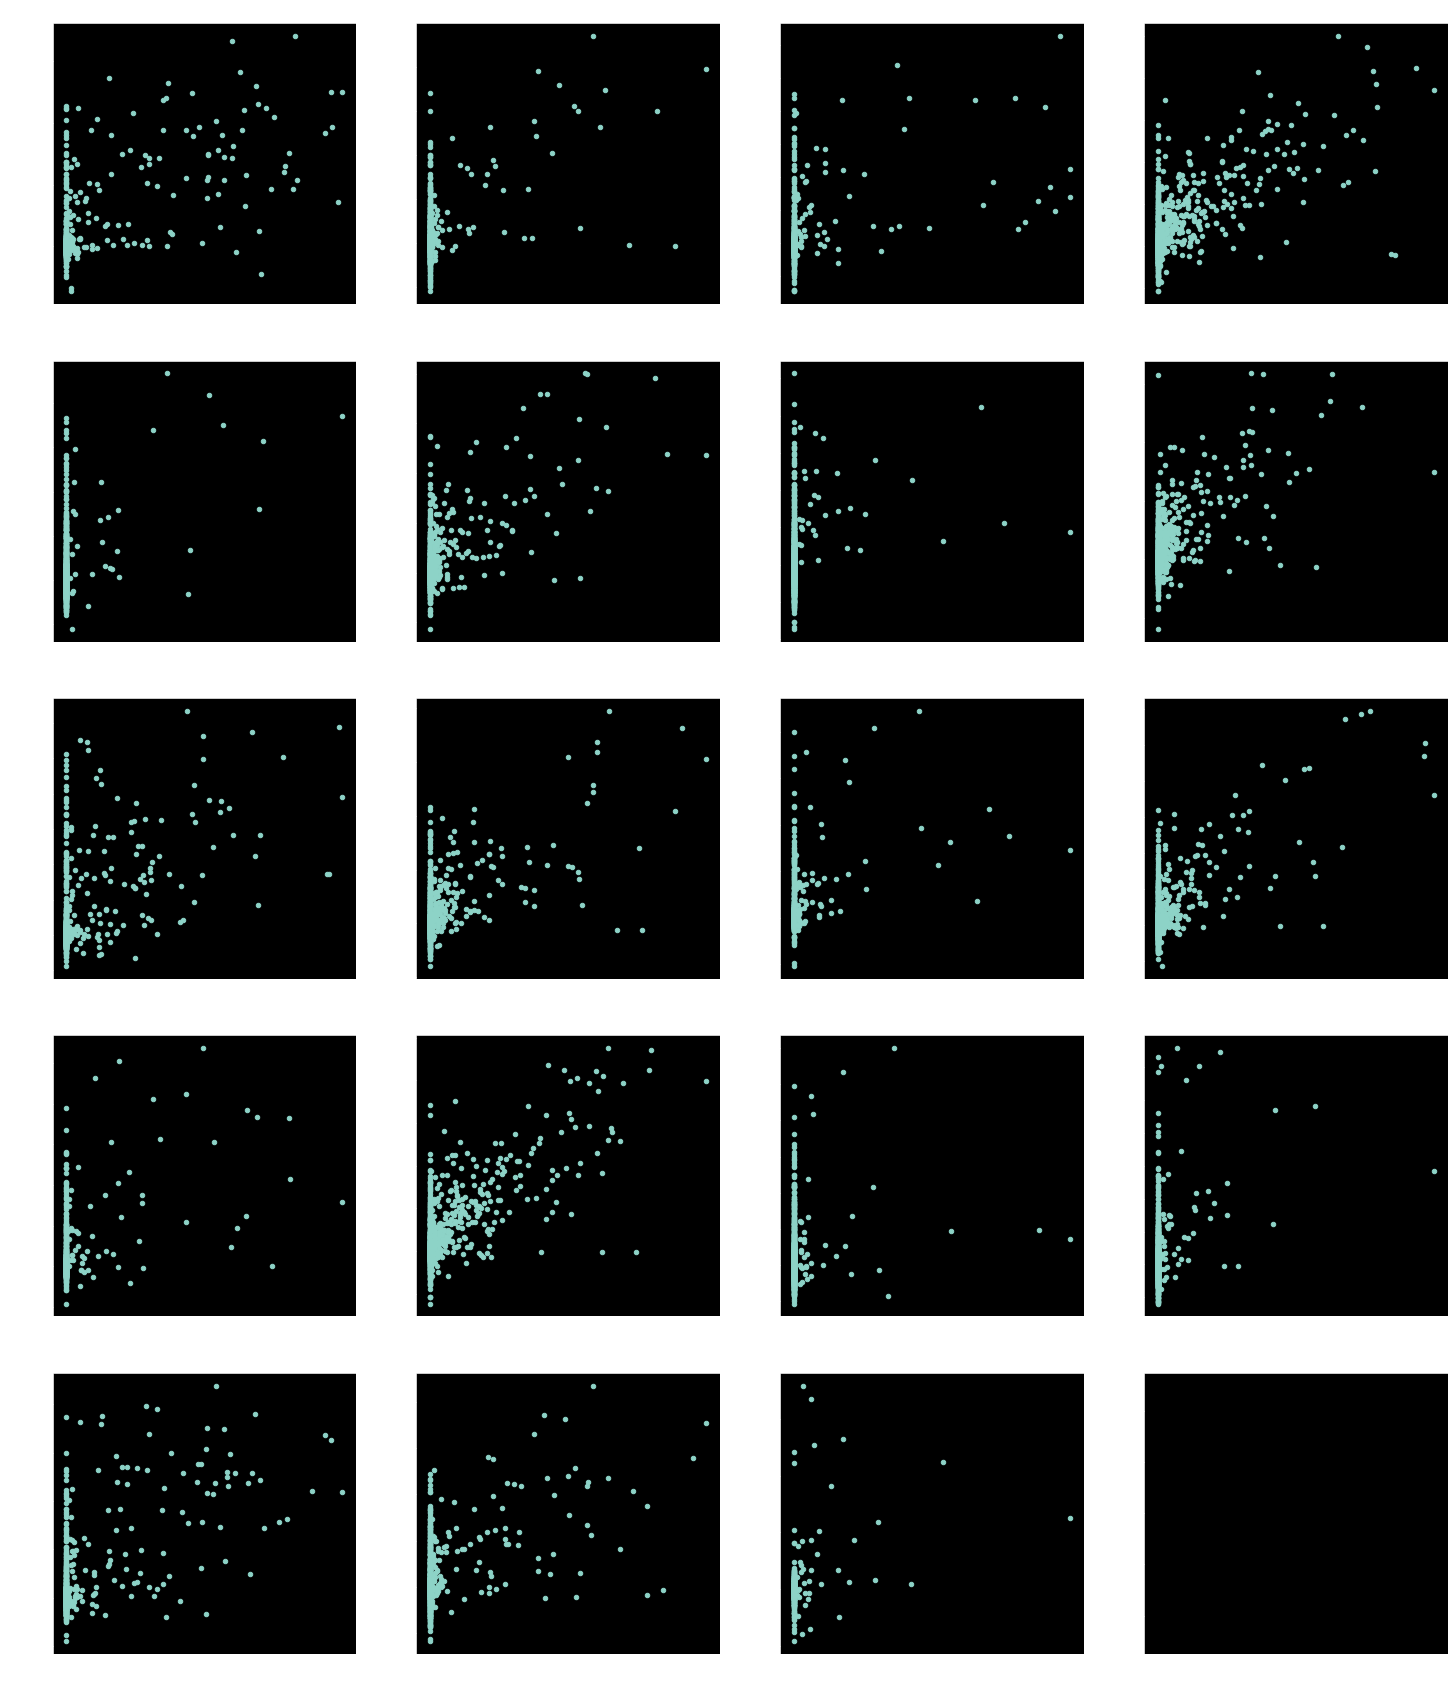

In [7]:
fig, axes = plt.subplots(ncols=4,nrows=5, figsize= (25, 30))
ax_list = axes.flat

regressor = "MLP"
train_setup = "all_feat"

i = 0
for (matrix, polarity), rows in models_results.groupby(['matrix', 'polarity']):
    rows = rows[rows["train_setup"] == train_setup]
    if not INCLUDE_NOT_DETECTED_IN_SCORE:
        rows = rows[rows["observed_value"] > 0]
    rows[rows.regressor == regressor].plot.scatter(x = 'observed_value', y= 'prediction',
                                                   ax = ax_list[i], title=f"{matrix}-{polarity}-{regressor}")
    i+=1

plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

